<a href="https://colab.research.google.com/github/YunTaeHyeon/SmartBuildingBigDataAnalyze/blob/main/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import re
import csv
import gensim
from sklearn.preprocessing import normalize
from itertools import combinations

Mounted at /content/drive


In [53]:
# CSV 파일 불러오기
data = pd.read_csv('/content/drive/MyDrive/경진대회 DATA/train_data.csv', encoding='cp1252')
test_data = pd.read_csv('/content/drive/MyDrive/경진대회 DATA/test_data.csv', encoding='cp1252')

df = data.rename(columns={'Àç½ÇÀÎ¿ø': 'person'})
test_df = test_data.rename(columns={'Àç½ÇÀÎ¿ø': 'person'})

# dust_pm1, dust_pm_25, dust_pm_10, illuminance 는 중요도가 낮고 인원에 관계없기 때문에 열 제거 (그래프에서 확인)
df = df.drop(["dust_pm1", "dust_pm_25", "dust_pm_10", "illuminance"], axis=1)
df = df.drop(["PIR"], axis=1) #상관관계가 거의 없음

test_df = test_df.drop(["dust_pm1", "dust_pm_25", "dust_pm_10", "illuminance"], axis=1)
test_df = test_df.drop(["PIR"], axis=1) #상관관계가 거의 없음

# 상호작용 항 생성 랜덤포레스트로 선정한 중요한 데이터에서 가장 높은 점수
df["temp_co2_interaction"] = df["temp"] * df["co2"]
test_df["temp_co2_interaction"] = test_df["temp"] * test_df["co2"]


# 필터링하여 중앙값으로 대체
filtered_df = df.copy()  # 복사본 생성
filtered_df.loc[filtered_df['eco2'] > 2700, 'eco2'] = filtered_df['eco2'].median()
test_df.loc[test_df['eco2'] > 2700, 'eco2'] = test_df['eco2'].median()

# 필터링하여 중앙값으로 대체
filtered_df.loc[filtered_df['voc'] > 1700, 'voc'] = filtered_df['voc'].median()
test_df.loc[test_df['voc'] > 1700, 'voc'] = test_df['voc'].median()




#df.to_csv('modified_train_data.csv', index=False)
#test_df.to_csv('test_data.csv', index=False)

filtered_df.describe()

#수정이 필요할 듯 함. correlation_of_data.ipynb에서는 평균값 그래프가 아닌 중앙값 그래프로 바꿔야하고 여기서는 그걸 반영해서 다시 해야함

,temp,humi,co2,voc,eco2,person,temp_co2_interaction
count,310742.000000,310742.000000,310742.000000,310742.000000,310742.000000,388800.000000,310742.000000
mean,20.757307,30.857824,586.669015,69.264753,771.385658,1.312199,12527.725877
std,2.226715,7.615024,294.935140,118.118968,387.177611,1.438593,7538.386486
min,13.700000,11.000000,30.000000,0.000000,400.000000,0.000000,657.000000
25%,19.200000,26.000000,395.000000,11.000000,477.000000,0.000000,7663.600000
50%,20.900000,30.000000,477.000000,36.000000,637.000000,1.000000,9738.400000
75%,22.300000,35.000000,697.000000,80.000000,933.000000,3.000000,15132.900000
max,26.800000,87.000000,2365.000000,1698.000000,2700.000000,6.000000,61726.500000


In [55]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

filtered_df = filtered_df.dropna(axis=0)
test_df = test_df.dropna(axis=0)

# Features와 Target 분리
X_train = filtered_df[['temp', 'humi', 'co2', 'voc', 'eco2', 'temp_co2_interaction']]
y_train = filtered_df['person']

# Min-Max 정규화
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)

# 랜덤 포레스트 회귀 모델 생성
rf = RandomForestRegressor()

# 모델 학습
rf.fit(X_train_normalized, y_train)

# test 데이터 전처리
X_test = test_df[['temp', 'humi', 'co2', 'voc', 'eco2', 'temp_co2_interaction']]
X_test_normalized = scaler.transform(X_test)

# 예측
y_pred = rf.predict(X_test_normalized)

# 예측 값을 반올림하여 정수형으로 변환
y_pred_rounded = y_pred.round().astype(int)

# 정확도 계산
accuracy = accuracy_score(test_df['person'], y_pred_rounded)
print('정확도:', accuracy)


정확도: 0.32005416862929814


In [47]:
# test_df에서 NaN 값 제거
test_df = test_df.dropna(axis=0)

# Features 추출
X_test = test_df[['temp', 'humi', 'co2', 'voc', 'eco2', 'temp_co2_interaction']]

# Min-Max 정규화
X_test_normalized = scaler.transform(X_test)

# 예측
y_pred_test = rf.predict(X_test_normalized)

r2_score = rf.score(X_test_normalized, y_pred_test)
print("R^2 Score:", r2_score)



# RandomForestClassifier 모델 생성
rf_classifier = RandomForestClassifier()

# 모델 학습
rf_classifier.fit(X_train, y_train)

# 예측
y_pred = rf_classifier.predict(X_test)

# 정확도 계산
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

R^2 Score: 1.0


# 이상치 관리

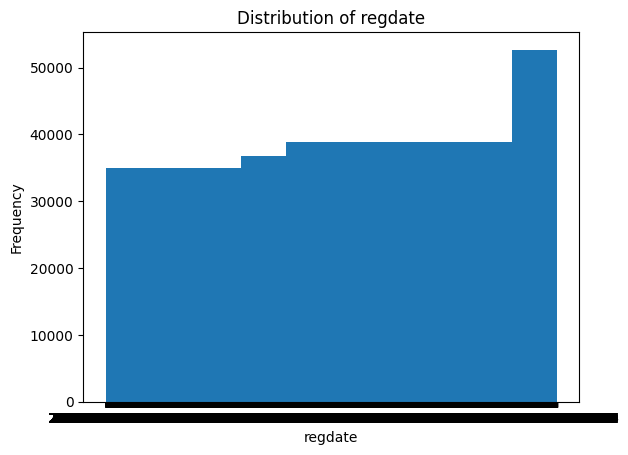

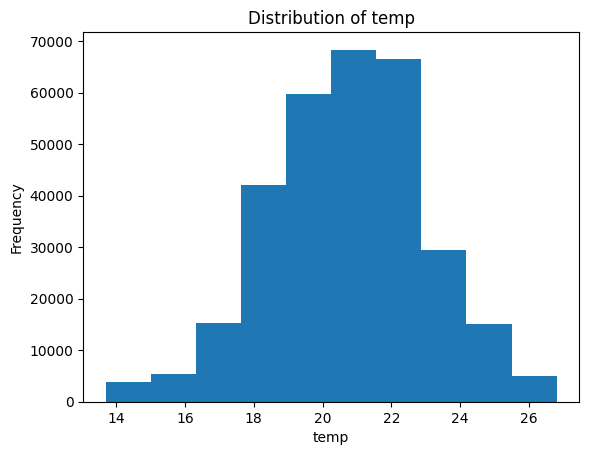

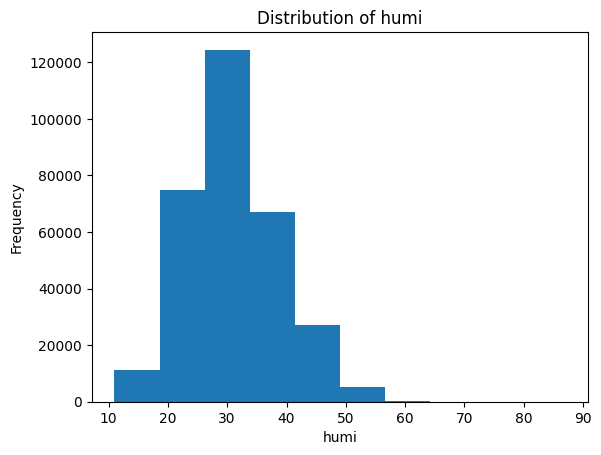

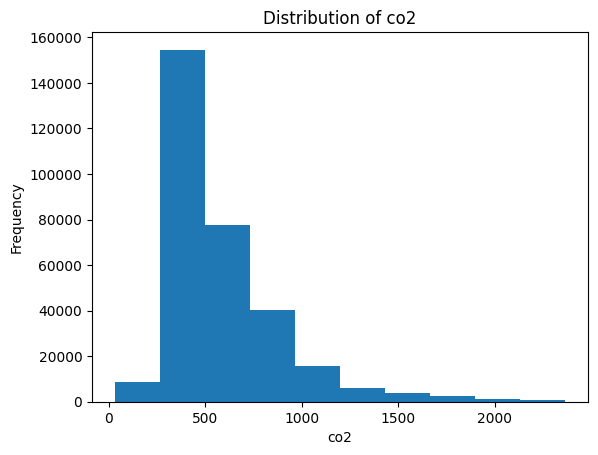

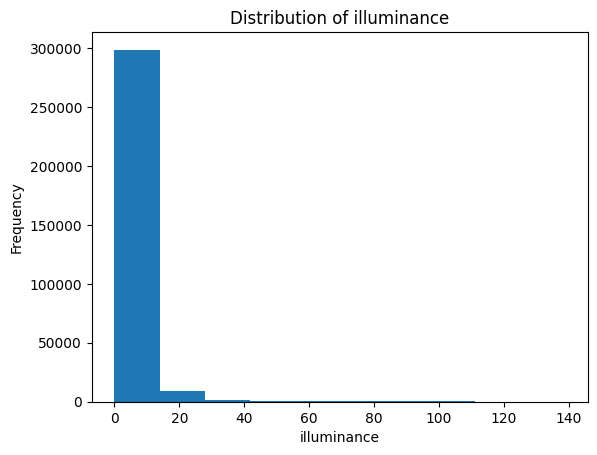

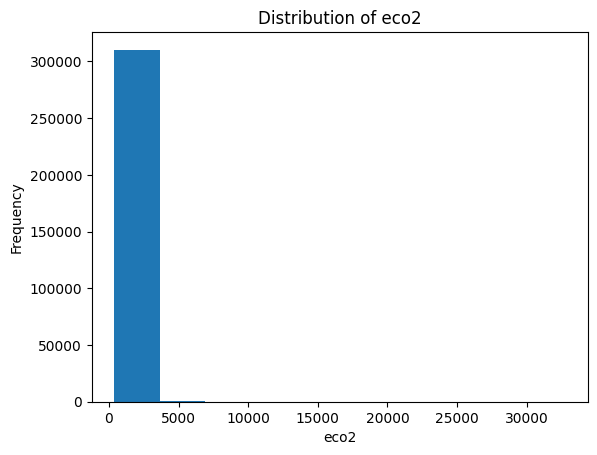

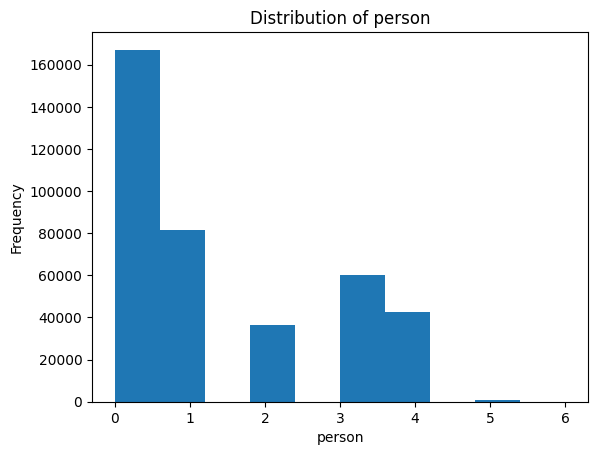

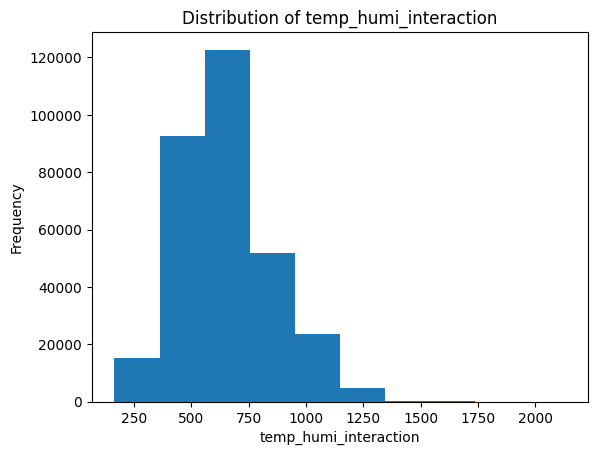

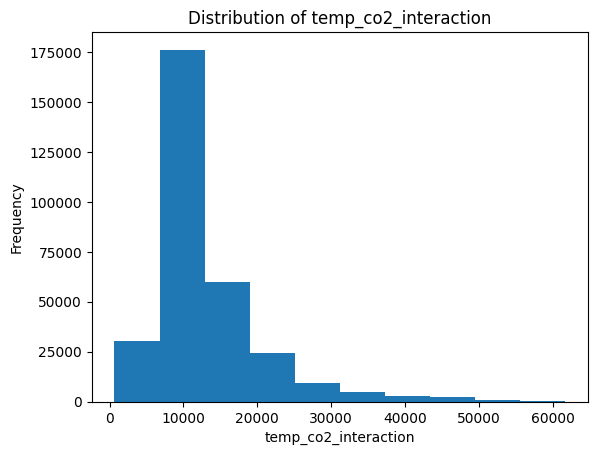

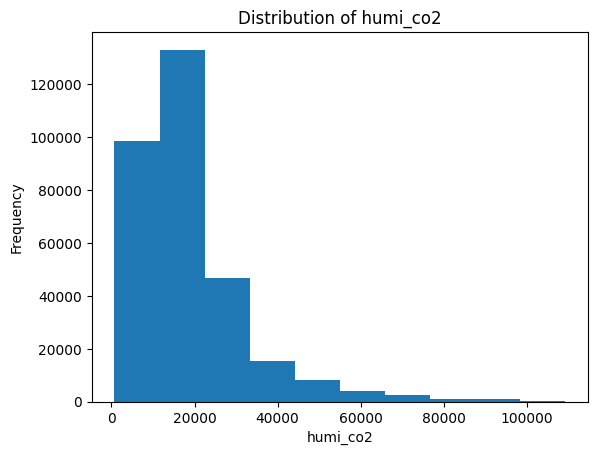

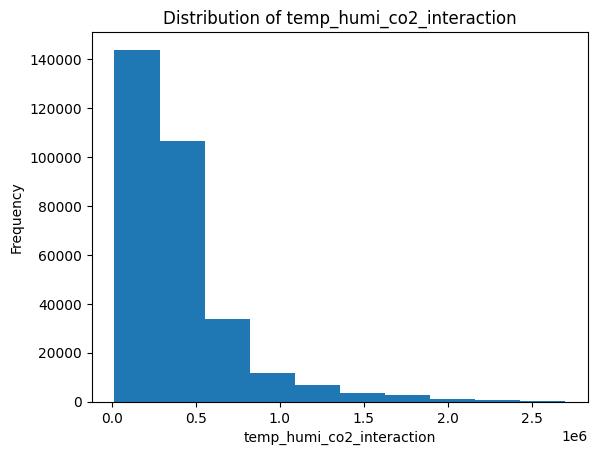

In [23]:
import matplotlib.pyplot as plt

# DataFrame의 각 열에 대한 분포를 시각화
for column in df.columns:
    plt.hist(list(df[column]), bins=10)  # 히스토그램 생성 (리스트로 변환)
    plt.xlabel(column)  # x축 레이블 설정
    plt.ylabel("Frequency")  # y축 레이블 설정
    plt.title(f"Distribution of {column}")  # 그래프 제목 설정
    plt.show()  # 그래프 출력

# 랜덤포레스트로 중요도 높은 값 찾기

In [17]:
'''import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from itertools import combinations

# CSV 파일 불러오기
data = pd.read_csv('/content/drive/MyDrive/경진대회 DATA/train_data.csv', encoding='cp1252')

# dust_pm1, dust_pm_25, dust_pm_10는 중요도가 낮기 때문에 열 제거
#df = data.drop(["dust_pm1", "dust_pm_25", "dust_pm_10"], axis=1)
#df = df.drop(["voc", "PIR"], axis=1)

df = data.rename(columns={'Àç½ÇÀÎ¿ø': 'person'})

# 숫자형 데이터 열 선택
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# 상호작용 항 생성
interaction_features = list(combinations(numeric_columns, 2))  # 모든 2개의 조합 생성

# 상호작용 항이 "person"과 상호작용하지 않도록 필터링
filtered_interaction_features = [feature for feature in interaction_features if 'person' not in feature]

for feature1, feature2 in filtered_interaction_features:
    interaction_feature = f"{feature1}_{feature2}"
    df[interaction_feature] = df[feature1] * df[feature2]

# NaN 값을 가진 행 제외하기
df = df.dropna()

# regdate 열 제외하기
df = df.drop("regdate", axis=1)

# Features와 Target 분리
X = df.drop("person", axis=1)
y = df["person"]

# 랜덤 포레스트 모델 생성
rf = RandomForestRegressor()

# 모델 학습
rf.fit(X, y)

# 변수 중요도 계산
importance = rf.feature_importances_

# 변수 중요도를 데이터프레임으로 생성
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# 중요도를 기준으로 내림차순 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 중요도 출력
for index, row in importance_df.iterrows():
    print(f"{row['Feature']}: {row['Importance']}")

#PIR, dust, voc는 없어도 되겠네요


temp_co2: 0.5746423610995336
temp: 0.06738572872519703
temp_illuminance: 0.037583372744510915
temp_humi: 0.03710875016218579
humi: 0.03487572814061041
humi_illuminance: 0.027018302028350462
co2: 0.02142984737015617
humi_co2: 0.01632016838328972
co2_illuminance: 0.011126797276689037
humi_eco2: 0.010898834906934253
co2_voc: 0.010121707007938125
co2_eco2: 0.010017830086486943
illuminance_eco2: 0.009696915282784043
temp_dust_pm1: 0.009631496347412012
temp_dust_pm_25: 0.00904294720856404
temp_eco2: 0.008119419900590856
humi_dust_pm1: 0.007372960811631882
temp_dust_pm_10: 0.006677785580897398
dust_pm1_illuminance: 0.005842952725403835
humi_dust_pm_25: 0.0055564223306308926
co2_dust_pm1: 0.005496604339392614
illuminance_voc: 0.005367741642862306
co2_dust_pm_25: 0.005274258114605067
dust_pm1_eco2: 0.005115775268887416
co2_dust_pm_10: 0.005088712491235162
dust_pm_10_voc: 0.004760638126946306
dust_pm_25_eco2: 0.004717035950031993
dust_pm_10_eco2: 0.00461714473824348
dust_pm_25_illuminance: 0.004

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# NaN 값을 가진 행 제외하기
df = df.dropna()

# regdate 열 제외하기
df = df.drop("regdate", axis=1)

# Features와 Target 분리
X = df.drop("person", axis=1)
y = df["person"]

# 랜덤 포레스트 모델 생성
rf = RandomForestRegressor()

# 모델 학습
rf.fit(X, y)

# 변수 중요도 계산
importance = rf.feature_importances_

# 중요도 출력
for i, feature in enumerate(X.columns):
    print(f"{feature}: {importance[i]}")


temp: 0.0993274469542712
humi: 0.04579147844143386
co2: 0.03550587522232136
illuminance: 0.07291455494900903
eco2: 0.06940344374200488
temp_humi_interaction: 0.0598227286903929
temp_co2_interaction: 0.5841001357352819
humi_co2: 0.018499656581630393
temp_humi_co2_interaction: 0.014634679683654561


KeyError: ignored